# Load Layer outputs

In [1]:
import pickle
with open('NN_layer_outputs.dat','rb') as f:
    layer_outs,layer_outs_test= pickle.load(f)
f.close()

# Load recording and test data

In [2]:
import numpy as np
from keras.datasets import mnist
from scipy.misc import imresize

(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

(ntrain, xdim, ydim) = Xtrain.shape
ntest = Xtest.shape[0]

# Recording data
X_pr = Xtrain[30000:60000, :, :]
Y_pr = Ytrain[30000:60000]

# downsample
factor = 0.25


Xtest_down = np.ones((Xtest.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(Xtest.shape[0]):
    Xtest_down[i,:,:] = imresize(Xtest[i,:,:], factor)

X_pr_down = np.ones((X_pr.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(X_pr.shape[0]):
    X_pr_down[i,:,:] = imresize(X_pr[i,:,:], factor)
    
# VECTORIZE IMAGES
Xtest_down = Xtest_down.reshape(ntest, int(xdim*factor)**2).astype('float32') / 255
X_pr_down = X_pr_down.reshape(X_pr_down.shape[0], int(xdim*factor)**2).astype('float32') / 255

Using TensorFlow backend.


# Run Neural Networks with missing value imputation

In [ ]:
from copy import copy, deepcopy
from RE_PartialRecData2 import RE_PartialRecData2
from sklearn import preprocessing, linear_model
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K
import tensorflow as tf



# how many recordings?
nRecordings = 10
# how many neurons from the firs hidden layer?
#subnetSize = [2**x for x in range(8)]
subnetSize =[1, 8, 64, 128]
nSubnetSize = len(subnetSize)
# which layers?
iLayer=0
# how many samples per recording?
nSamples = np.divide(int(X_pr_down.shape[0]/nRecordings),subnetSize)*100
#nSamples=[100 for i in range(nSubnetSize)]
# how many iterations
nIterations = 5

# baseline prediction error
#bl = np.std(layer_outs_test[oLayer]-np.mean(layer_outs_test[oLayer]));

oLayer = len(layer_outs)-1  # index of output layer
nOutNeurons = layer_outs[oLayer].shape[1]
rmses = np.zeros([nIterations, nOutNeurons, nSubnetSize])
for ss in range(nSubnetSize):
    r_coefs =np.zeros((nIterations, 10, 128))
    #nLayerNeurons = [subnetSize[ss], 0, 0, 0, 10]
    nLayerNeurons = subnetSize[ss]
    print(subnetSize[ss])
    for it in range(nIterations):
        # copy data - is this necessary?
        layer_outputs = deepcopy(layer_outs)
        # subsample
        X_subsample, Y_subsample = RE_PartialRecData2(layer_outputs[iLayer], layer_outputs[oLayer], \
                                                      nLayerNeurons, nRecordings, nSamples[ss])
        # impute X_subsample with mean value, apply imputation to test set
        imp =preprocessing.Imputer(missing_values='NaN', strategy='mean')
        impf =imp.fit(X_subsample)
        X_new = impf.transform(X_subsample)
        # apply the transformation to X_test to drop entirely nan columns
        X_test_new= impf.transform(layer_outs_test[iLayer]) 
        # train the network
        model = Sequential()
        model.add(Dense(50, input_shape=( X_new.shape[1] ,)))
        model.add(Dense(50, activation ='tanh'))
        model.add(Dense(50))
        model.add(Dense(10))
        # Compile model
        model.compile(loss='mean_squared_error', optimizer='adam')        
        model.fit(X_new, Y_subsample, verbose=2, batch_size=500)
        rmses[it, :,ss] =np.sqrt(np.mean((model.predict(X_test_new, verbose=0)-layer_outs_test[oLayer])**2, axis=0))
        
        # fit regression model
        #regr = linear_model.Lasso(0.01) 
        print ('predicting, mean RMSEs=%f' %np.mean(rmses[it, :, ss]))
#         if np.mean(rmses[it, :, ss])>1:
#             breakflag=True
#             break
#     if breakflag:
#         break

            
# # save the rmse's
# with open('RMSE_Layer1_NLNN.dat','wb') as f:
#     pickle.dump(rmses, f)
# f.close()


1
Epoch 1/10
22s - loss: 0.0846
Epoch 2/10
23s - loss: 0.0841
Epoch 3/10
22s - loss: 0.0839
Epoch 4/10
22s - loss: 0.0837
Epoch 5/10
23s - loss: 0.0836
Epoch 6/10
24s - loss: 0.0836
Epoch 7/10
23s - loss: 0.0836
Epoch 8/10
23s - loss: 0.0835
Epoch 9/10


(0, 2.5)

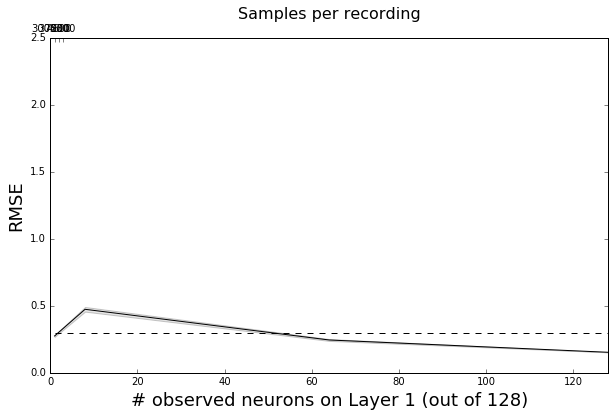

In [4]:

import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np

fig=pl.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.set_xlim([0, 128])
ax2 = ax1.twiny()

x = subnetSize;
y = np.mean(np.median(rmses, axis=1), axis=0)
error = np.std(np.mean(rmses, axis=1), axis=0)
bl = np.std(layer_outs_test[oLayer]-np.mean(layer_outs_test[oLayer]));

pl.plot(x, y, 'k-')
horiz_line_data = np.array([bl for i in xrange(len(x))])
pl.plot(x, horiz_line_data, 'k--') 
pl.fill_between(x, y-error, y+error, alpha=0.2, facecolor='#808080')

ax1.set_xlabel('# observed neurons on Layer 1 (out of 128)', fontsize=18)
ax2.set_xlabel('Samples per recording',  fontsize=16)

new_tick_locations =range(len(nSamples))
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(nSamples)


# ax2.set_xticks(nSamples)
# ax2.set_xticklabels(nSamples[range(0, 5, 20)])
ax1.set_ylabel('RMSE', fontsize=18)
ax1.set_ylim([0, 2.5])

#pl.text(110,bl+0.005, 'baseline')

In [ ]:
nRecordings=10
hLayerOuts =layer_outs[iLayer]
nSamples = 20
nLayerNeurons =64
oLayerOuts = layer_outs[oLayer]
import numpy as np
# returns a data set where, nLayerNeurons are recorded from a hidden layer, for each of nRecordings.
# Each partial recording has nSamples.
layerArray = np.zeros((nRecordings, nLayerNeurons), dtype=int)
for iRec in range(nRecordings):
    layerArray[iRec, :]= np.sort(np.random.choice(range(hLayerOuts.shape[1]), size=nLayerNeurons, replace=False))      

#print(layerArray)
X = np.nan*np.zeros((nRecordings*nSamples, hLayerOuts.shape[1]))
Y = np.nan*np.zeros((nRecordings*nSamples, oLayerOuts.shape[1]))

# get the data
sample_ind=0
for iRec in range(nRecordings):
    rec_inds = np.random.choice(range(hLayerOuts.shape[0]), size=nSamples, replace=True)
    #print(rec_inds)
    cols = layerArray[iRec, :]
    cols = cols[:, None]
    inds = np.array(range(sample_ind,((iRec+1)*nSamples)), dtype=int)
    X[inds, cols] = hLayerOuts[rec_inds, cols]
    Y[inds, :] = oLayerOuts[rec_inds, :]
    sample_ind = sample_ind + nSamples

In [ ]:
print(oLayerOuts[rec_inds, :])
print(Y[inds, :])